# 1D Heat equation; PINN

In [31]:
# initial plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image

We will store the temperature u, at a given x,t in a 2D tensor called U(t,x)

In [32]:
# setup time-space geometry
num_points = 51
x_start = 0
x_stop = 1
num_timesteps = 1000
t_start = 0
t_stop = 1 
x = np.linspace(start=x_start, stop=x_stop, num=num_points)
t = np.linspace(start=t_start, stop=t_stop, num=num_timesteps)

## PINN to learn the 1D-heat diffusion equation

The goal of the following section is to show a PINN using:

- Initial condition loss
- Boundary condition loss
- PDE loss
- Data driven loss

In [33]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [34]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [35]:
U_load = np.load("./1d-heat.npy")
print(f"U shape: {U_load.shape}")

U shape: (1000, 51)


In [36]:
#Store x,t in a feature array of 2 columns
features = np.ones((U_load.shape[0]*U_load.shape[1],2))
features[:,1] = np.tile(x,U_load.shape[0])
features[:,0] = np.repeat(t,U_load.shape[1])
print(f"First 5 features {features[0:5]}\n")
print(f"Last 5 features  {features[-5:]}")

First 5 features [[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]

Last 5 features  [[1.   0.92]
 [1.   0.94]
 [1.   0.96]
 [1.   0.98]
 [1.   1.  ]]


In [37]:
labels = np.ones((U_load.shape[0]*U_load.shape[1],1))
labels = U_load.ravel()
print(f"First 5 temperature label data: {labels[0:5]}")

First 5 temperature label data: [0.         0.06279052 0.12533323 0.18738131 0.24868989]


In [38]:
#Set datatype expected by PyTorch
labels = labels.astype(np.float32)
features = features.astype(np.float32)

Data now needs pre-processing ready for PyTorch training including:

- Feature scaling
- Train-test splitting for model validation

In [39]:
### Pre-processing stage
std_scaler = StandardScaler()
scaler_features = std_scaler.fit(features)
scaled_features = scaler_features.transform(features)

print(f"\nPre-scaling:\n {features[0:5]}")
print(f"Mean: {features.mean()} Std: {features.std()}")
print(f"\nPost-scaling:\n {scaled_features[0:5]}")
print(f"Mean: {scaled_features.mean()} Std: {scaled_features.std()}")


Pre-scaling:
 [[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
Mean: 0.5000000596046448 Std: 0.2916906177997589

Post-scaling:
 [[-1.7303196 -1.6984155]
 [-1.7303196 -1.6304789]
 [-1.7303196 -1.5625423]
 [-1.7303196 -1.4946057]
 [-1.7303196 -1.426669 ]]
Mean: 2.1541818995274298e-08 Std: 1.0


In [40]:
# Get feature data for initial condition, boundary condition and interior points
features_init = scaled_features[0:51]

features_x0 = scaled_features[0::51]
features_xstop = scaled_features[50::51]
features_bound = np.append(features_x0, features_xstop, axis=0)

features_interior = np.empty((0,1))
start=1
block_size=49
skip=2
while start < features.shape[0]:
    features_interior = np.append(features_interior, scaled_features[start:start+block_size])
    start = start + block_size + skip

length = features_interior.ravel().shape[0]
features_interior = features_interior.reshape((int(length/2),2))

#Now split them into x and t as this is more generic for future multi-dimensional 
t_init = features_init[:, 0]
t_bound = features_bound[:, 0]
t_interior = features_interior[:, 0]
x_init = features_init[:, 1]
x_bound = features_bound[:, 1]
x_interior = features_interior[:, 1]

print(f"Time vals init condition shape: {t_init.shape}")
print(f"Time vals boundary condition shape: {t_bound.shape}")
print(f"Time vals interior condition shape: {t_interior.shape}")
print(f"Space vals init condition shape: {x_init.shape}")
print(f"Space vals boundary condition shape: {x_bound.shape}")
print(f"Space vals interior shape: {x_interior.shape}")

Time vals init condition shape: (51,)
Time vals boundary condition shape: (2000,)
Time vals interior condition shape: (49000,)
Space vals init condition shape: (51,)
Space vals boundary condition shape: (2000,)
Space vals interior shape: (49000,)


In [41]:
# Get label data for initial condition, boundary condition and interior points
labels_init = labels[0:51]

labels_x0 = labels[0::51]
labels_xstop = labels[50::51]
labels_bound = np.append(labels_x0, labels_xstop, axis=0)

labels_interior = np.empty((0,1))
start=1
block_size=49
skip=2
while start < labels.shape[0]:
    labels_interior = np.append(labels_interior, labels[start:start+block_size])
    start = start + block_size + skip

print(f"Labels for init condition shape: {labels_init.shape}")
print(f"Labels for left boundary condition shape: {labels_x0.shape}")
print(f"Labels for right boundary condition shape: {labels_xstop.shape}")
print(f"\tLabels for both boundary condition shape: {labels_bound.shape}")
print(f"Labels for interior shape: {labels_interior.shape}")

Labels for init condition shape: (51,)
Labels for left boundary condition shape: (1000,)
Labels for right boundary condition shape: (1000,)
	Labels for both boundary condition shape: (2000,)
Labels for interior shape: (49000,)


In this next section I need to take the output from above and get it into a Dataset/DataLoader format to be used by the model

In [42]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """_summary_
        """
        super().__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

    def forward(self, x, t):
        """_summary_

        Args:
            x (_type_): _description_
            t (_type_): _description_

        Returns:
            _type_: _description_
        """
        inputs = torch.cat([x,t], axis=1).to(device)
        return self.linear_stack(inputs)
    
def train_loop(x_bound, x_init, x_interior, t_bound, t_init, t_interior,labels_bound, labels_init, labels_interior, model, loss_fn, optimizer, phy_weight, data_weight):
    """_summary_

    Args:
        x_bound (_type_): _description_
        x_init (_type_): _description_
        x_interior (_type_): _description_
        t_bound (_type_): _description_
        t_init (_type_): _description_
        t_interior (_type_): _description_
        labels_bound (_type_): _description_
        labels_init (_type_): _description_
        labels_interior (_type_): _description_
        model (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
    """
    optimizer.zero_grad()

    interior_pred = model(x_interior, t_interior)
    bound_pred = model(x_bound, t_bound)
    init_pred = model(x_init, t_init)
    
    boundary_loss, initial_loss, pde_loss, data_loss = \
        loss_fn(
            interior_pred, bound_pred, init_pred, 
            labels_interior, labels_bound, labels_init, 
            x_interior, t_interior, 
            phy_weight, data_weight)
    
    # print(f"Total loss: {total_loss}")
    # print(f"\tPhysics loss: {physics_loss}")
    print(f"\tBefore adaption: Initial condition loss: {initial_loss}")
    print(f"\tBefore adaption: Boundary condition loss: {boundary_loss}")
    print(f"\tBefore adaption: PDE loss: {pde_loss}")
    print(f"\tBefore adaption: Data loss: {data_loss}")

    #Calculate dBoundaryLoss/dTheta
    boundary_loss.backward(retain_graph=True)
    bound_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            bound_grads.append(param.grad.view(-1))
    
    bound_grads = torch.cat(bound_grads)
    optimizer.zero_grad()
    
    #Calculate dInitialLoss/dTheta
    initial_loss.backward(retain_graph=True)
    init_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            init_grads.append(param.grad.view(-1))
    
    init_grads = torch.cat(init_grads)
    optimizer.zero_grad()

    #Calculate dInitialLoss/dTheta
    pde_loss.backward(retain_graph=True)
    pde_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            pde_grads.append(param.grad.view(-1))
    
    pde_grads = torch.cat(pde_grads)
    optimizer.zero_grad()

    #Calculate dDataLoss/dTheta
    data_loss.backward(retain_graph=True)
    data_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            data_grads.append(param.grad.view(-1))    
    
    data_grads = torch.cat(data_grads)
    optimizer.zero_grad()

    #Compute adaptive weight for each component of total loss
    #relative to the mean gradient of data_loss w.r.t layer weights
    boundary_loss_weight = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(bound_grads))
    init_loss_weight = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(init_grads))
    pde_loss_weight = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(pde_grads))

    #Create total loss to update all network parameters
    total_loss = \
        (data_loss) + \
        (init_loss_weight * initial_loss) + \
        (pde_loss_weight * pde_loss) + \
        (boundary_loss_weight * boundary_loss)
    
    print(f"\tAfter adaption: Initial condition loss: {initial_loss * init_loss_weight}")
    print(f"\tAfter adaption: Boundary condition loss: {boundary_loss * boundary_loss_weight}")
    print(f"\tAfter adaption: PDE loss: {pde_loss * pde_loss_weight}")
    print(f"\tAfter adaption: Data loss: {data_loss}")
    
    total_loss.backward()
    optimizer.step()

In [43]:
def combined_physics_data_loss(interior_pred, bound_pred, init_pred, interior_labels, bound_labels, init_labels, x_interior, t_interior, phy_weight, data_weight):
    """_summary_

    Args:
        interior_pred (_type_): _description_
        bound_pred (_type_): _description_
        init_pred (_type_): _description_
        interior_labels (_type_): _description_
        bound_labels (_type_): _description_
        init_labels (_type_): _description_
        x_interior (_type_): _description_
        t_interior (_type_): _description_
        phy_weight (_type_): _description_
        data_weight (_type_): _description_

    Returns:
        _type_: _description_
    """
    dudx = torch.autograd.grad(interior_pred.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    dudt = torch.autograd.grad(interior_pred.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    pde_values = (dudx * d2udt2) - dudt
    
    mse = torch.nn.MSELoss()
    pde_zeros = torch.zeros_like(pde_values)
    pde_loss = mse(pde_values,pde_zeros)
    initial_loss = mse(labels_init, init_pred)
    boundary_loss = mse(labels_bound, bound_pred)
    data_loss = mse(interior_pred, interior_labels)
    
    return boundary_loss, initial_loss, pde_loss, data_loss

In [44]:
#PINN Model training setup
model = NeuralNetwork()
model.to(device)
loss_fn = combined_physics_data_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Place input tensors on Device
x_interior=torch.from_numpy((x_interior.reshape(x_interior.shape[0],1))).float().requires_grad_().to(device)
t_interior=torch.from_numpy(t_interior.reshape(t_interior.shape[0],1)).float().requires_grad_().to(device)
x_init=torch.from_numpy(x_init.reshape(x_init.shape[0],1)).float().requires_grad_().to(device)
t_init=torch.from_numpy(t_init.reshape(t_init.shape[0],1)).float().requires_grad_().to(device)
x_bound=torch.from_numpy(x_bound.reshape(x_bound.shape[0],1)).float().requires_grad_().to(device)
t_bound=torch.from_numpy(t_bound.reshape(t_bound.shape[0],1)).float().requires_grad_().to(device)
labels_bound=torch.from_numpy(labels_bound.reshape(labels_bound.shape[0],1)).float().requires_grad_().to(device)
labels_init=torch.from_numpy(labels_init.reshape(labels_init.shape[0],1)).float().requires_grad_().to(device)
labels_interior=torch.from_numpy(labels_interior.reshape(labels_interior.shape[0],1)).float().requires_grad_().to(device)

phy_weight = 1
data_weight = 1

epochs = 1000
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}\n-------------------------------")
    train_loop(x_bound, x_init, x_interior,\
                t_bound, t_init, t_interior,\
                labels_bound, labels_init, labels_interior,\
                model, loss_fn, optimizer,\
                phy_weight, data_weight)
print("\nTraining complete!\n")


Streaming output truncated to the last 5000 lines.
	After adaption: Boundary condition loss: 0.08822434395551682
	After adaption: PDE loss: 0.18366429209709167
	After adaption: Data loss: 0.19249378144741058

Epoch 547
-------------------------------
	Before adaption: Initial condition loss: 2.0797315301024355e-05
	Before adaption: Boundary condition loss: 1.753295691742096e-05
	Before adaption: PDE loss: 9.07604680833174e-06
	Before adaption: Data loss: 0.19181980192661285
	After adaption: Initial condition loss: 0.06290854513645172
	After adaption: Boundary condition loss: 0.0580727644264698
	After adaption: PDE loss: 0.18776564300060272
	After adaption: Data loss: 0.19181980192661285

Epoch 548
-------------------------------
	Before adaption: Initial condition loss: 5.2864201279589906e-05
	Before adaption: Boundary condition loss: 3.948655285057612e-05
	Before adaption: PDE loss: 5.737333594879601e-06
	Before adaption: Data loss: 0.18784035742282867
	After adaption: Initial conditi

In [45]:
#Save the model for future use
#output_model_path = os.getcwd() + "/model.pt"
#torch.save(model, output_model_path)

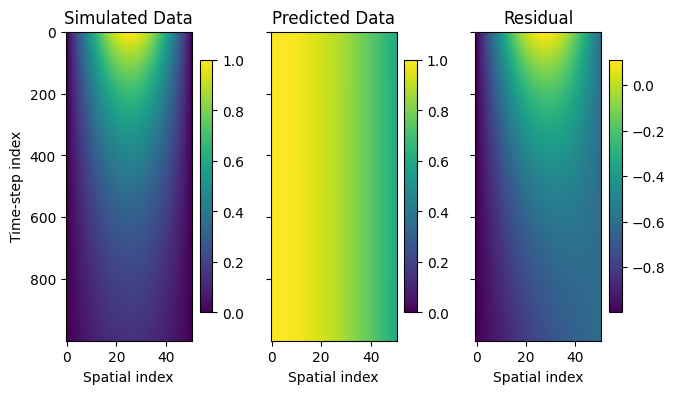

In [54]:
def result_plot(simulation, prediction):
    """_summary_

    Args:
        simulation (_type_): _description_
        prediction (_type_): _description_
    """
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.tight_layout()

    # Min and max of real data so plots share limits
    sim_min = np.min(simulation)
    sim_max = np.max(simulation)
    
    sim_im = ax1.imshow(simulation, aspect=0.125, vmin=sim_min, vmax=sim_max)
    pred_im = ax2.imshow(prediction, aspect=0.125, vmin=sim_min, vmax=sim_max)
    res_im = ax3.imshow(simulation-np.asarray(prediction), aspect=0.125) #vmin=sim_min, vmax=sim_max)

    # Colorbars
    f.colorbar(sim_im, orientation='vertical', shrink=0.6)
    f.colorbar(pred_im, orientation='vertical', shrink=0.6)
    f.colorbar(res_im, orientation='vertical', shrink=0.6)  
    
    #Titles and labels
    ax1.set_title("Simulated Data")
    ax1.set_ylabel("Time-step index")
    ax1.set_xlabel("Spatial index")
    ax2.set_title("Predicted Data")
    ax2.set_xlabel("Spatial index")
    ax3.set_title("Residual")
    ax3.set_xlabel("Spatial index")
    
    # Make spacing suitable
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
    #f.savefig("output_img.png")

# Model inferencing and QC
t = features[:, 0]
x = features[:, 1]

with torch.inference_mode():
    prediction = model(torch.Tensor(x).reshape((x.shape[0],1)),
                       torch.Tensor(t).reshape((t.shape[0],1)))

prediction = prediction.reshape_as(torch.Tensor(U_load))
prediction = prediction.cpu().detach().numpy()
simulation = U_load

result_plot(simulation,prediction)